In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import datetime, statsmodels, warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
from sklearn.metrics import mean_squared_error
from math import sqrt
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta
import ipywidgets as widgets

In [3]:
pip install requests pandas plotly chart-studio python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install pymannkendall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import chart_studio
import chart_studio.plotly as py

In [6]:
from google.colab import files
uploaded1=files.upload()

Saving CPI.xlsx to CPI (1).xlsx


In [7]:
data=pd.read_excel("CPI.xlsx")
data

,observation_date,Monthly_CPI,Ln_Monthly_CPI
0,1995-01-01,1.904146,0.644034
1,1995-02-01,1.917188,0.650860
2,1995-03-01,1.975878,0.681013
3,1995-04-01,2.145425,0.763338
4,1995-05-01,2.230198,0.802091
...,...,...,...
325,2022-02-01,160.946315,5.081071
326,2022-03-01,162.256597,5.089179
327,2022-04-01,164.731574,5.104317
328,2022-05-01,166.769791,5.116614


In [8]:
#Generate a widget
widget = widgets.IntRangeSlider(value=[1995, 2022], min=1995, max=2022, step=1, description='Time Period:', 
        disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget
#Prepare Data
years = widget.value
years = list(range(years[0],years[1]+1))
data['Year'] = pd.DatetimeIndex(data['observation_date']).year
data['Month'] = [d.strftime('%b') for d in data.observation_date]
#Draw Plot
fig = go.Figure()
for i,y in enumerate(years):
    if i<len(years):
        fig.add_trace(go.Scatter(
            x=data[data['Year']==years[i]].Month.tolist(),
            y=data[data['Year']==years[i]].Ln_Monthly_CPI.round(2).tolist(),
            name=str(years[i])))
fig.update_layout(title=go.layout.Title(
        text="Seasonal Trend of Monthly CPI (1995-2022)",
        xref="paper",
        x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="(ln) CPI",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))
fig.update_yaxes(nticks=10)

fig.show()

In [9]:
data["Dummy"]=0
data.iloc[data.index[data["observation_date"]=="1999-09-01"],5]=1
data.iloc[data.index[data["observation_date"]=="2000-08-01"],5]=1
data.iloc[data.index[data["observation_date"]=="2000-09-01"],5]=1
data.iloc[data.index[data["observation_date"]=="2000-11-01"],5]=1
data.iloc[data.index[data["observation_date"]=="2001-02-01"],5]=1
data.iloc[data.index[data["observation_date"]=="2001-03-01"],5]=1

In [10]:
Train = data[data.Year < 2014]
Test = data[data.Year > 2013]

In [11]:
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train.Ln_Monthly_CPI, mode='lines', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=Test.observation_date, y=Test.Ln_Monthly_CPI, mode='lines', name= 'Test')))

fig.update_layout(title=go.layout.Title(
        text="Monthly CPI for 1995 - first half of 2022",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="black"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="CPI",font=dict(
                family="Courier New, monospace",
                size=18,
                color="black"))))


fig.show()

In [12]:
import pymannkendall as mk
mk.original_test(Train["Ln_Monthly_CPI"])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=22.310257955559663, Tau=0.9926192132313162, s=25687.0, var_s=1325512.3333333333, slope=0.01489215656965696, intercept=2.342328616237322)

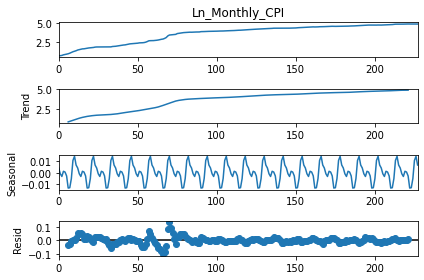

In [13]:
result = seasonal_decompose(Train['Ln_Monthly_CPI'].dropna(), model='additive', period =12)
result.plot()
plt.show()

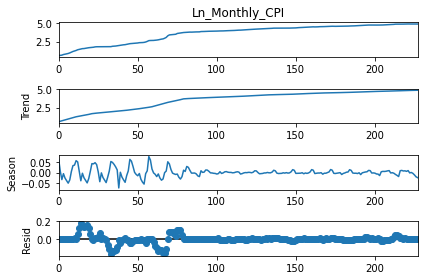

In [14]:
stl_mod = sm.tsa.STL(Train["Ln_Monthly_CPI"], robust=True,period=12)
stl_res = stl_mod.fit()
stl_seasonal = stl_res.seasonal
stl_trend = stl_res.trend
detrended=Train["Ln_Monthly_CPI"]-stl_trend
deseasonalized=(Train["Ln_Monthly_CPI"]-stl_seasonal).rename("deseasonalized")
stl_res.plot()
plt.show()


In [15]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=ts, mode='lines', name= 'Original Data')))
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=rol_mean, mode='lines', name= 'Rolling Mean',line=dict(color='black', width=2))))
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=rol_std, mode='lines', name= 'Rolling Standard',line=dict(color='brown', width=2))))

    fig.update_layout(title=go.layout.Title(
        text="Rolling Mean & Standard Deviation",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="(ln) CPI",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

    fig.show()



In [16]:
TestStationaryPlot(Train["Ln_Monthly_CPI"])

In [17]:
from statsmodels.tsa.stattools import adfuller
adfuller(Train["Ln_Monthly_CPI"])

(-2.736720191763108,
 0.06789674598480457,
 7,
 220,
 {'1%': -3.4604283689894815,
  '5%': -2.874768966942149,
  '10%': -2.57382076446281},
 -1099.2551980235473)

In [18]:
import statsmodels.api as sm
sm.tsa.stattools.kpss(Train["Ln_Monthly_CPI"])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(1.3896152590822637,
 0.01,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [19]:
Train_first_difference = Train["Ln_Monthly_CPI"] - Train["Ln_Monthly_CPI"].shift(1)  
TestStationaryPlot(Train_first_difference.dropna(inplace=False))

In [20]:
adfuller(Train_first_difference.dropna())

(-3.54497998277785,
 0.00690432230686202,
 6,
 220,
 {'1%': -3.4604283689894815,
  '5%': -2.874768966942149,
  '10%': -2.57382076446281},
 -1091.6834900993258)

In [21]:
sm.tsa.stattools.kpss(Train_first_difference.dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(0.8212809491236942,
 0.01,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [22]:
Train_second_difference = Train_first_difference - Train_first_difference.shift(1)  
TestStationaryPlot(Train_second_difference.dropna(inplace=False))

In [23]:

adfuller(Train_second_difference.dropna())

(-7.843116092920669,
 5.8648723135896335e-12,
 10,
 215,
 {'1%': -3.461136478222043,
  '5%': -2.875078880098608,
  '10%': -2.5739861168199027},
 -1079.4357969680318)

In [24]:
sm.tsa.stattools.kpss(Train_second_difference.dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.043114341249283206,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [25]:
Train_seasonal_difference = Train["Ln_Monthly_CPI"] - Train["Ln_Monthly_CPI"].shift(12)
TestStationaryPlot(Train_seasonal_difference.dropna(inplace=False))

In [26]:
adfuller(Train_seasonal_difference.dropna())

(-2.051988688446237,
 0.26425294148735157,
 13,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 -966.9393572193542)

In [27]:
sm.tsa.stattools.kpss(Train_seasonal_difference.dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(0.8388895250949711,
 0.01,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [28]:
Train_seasonal_first_difference = Train_seasonal_difference - Train_seasonal_difference.shift(1)  
TestStationaryPlot(Train_seasonal_first_difference.dropna(inplace=False))


In [29]:
adfuller(Train_seasonal_first_difference.dropna())

(-4.285372780447861,
 0.0004708463078699384,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 -959.7725150270899)

In [30]:
sm.tsa.stattools.kpss(Train_seasonal_first_difference.dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.07913318684562601,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

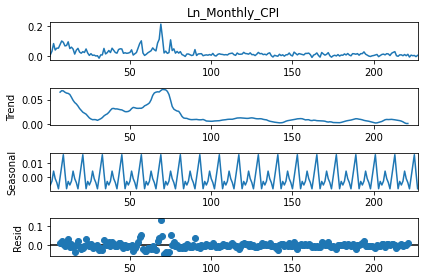

In [31]:
result = seasonal_decompose(Train_first_difference.dropna(), model='additive', period =12)
result.plot()
plt.show()

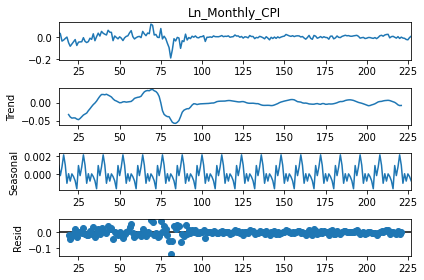

In [32]:
result = seasonal_decompose(Train_seasonal_first_difference.dropna(), model='additive', period =12)
result.plot()
plt.show()

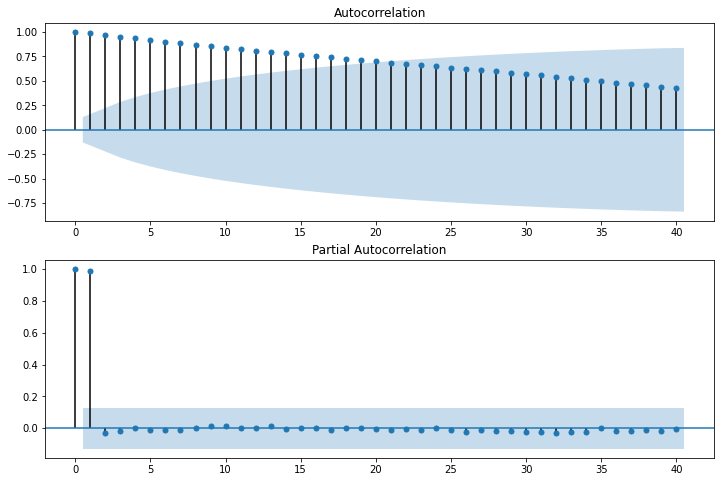

In [33]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

#Autocorrelation Graph for 40 periods
fig = sm.graphics.tsa.plot_acf(Train["Ln_Monthly_CPI"].dropna(), lags=40, ax=ax1)

#Partial autocorrelation Graph for 40 periods
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Train["Ln_Monthly_CPI"].dropna(), lags=40, ax=ax2)

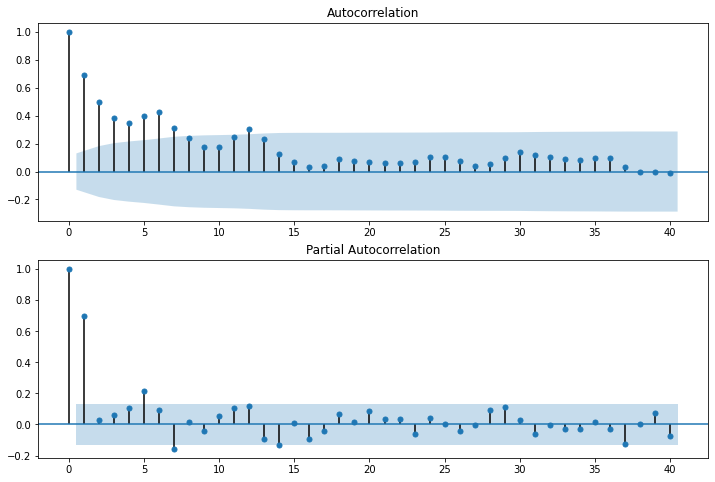

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

#Autocorrelation Graph for 40 periods
fig = sm.graphics.tsa.plot_acf(Train_first_difference.dropna(), lags=40, ax=ax1)

#Partial autocorrelation Graph for 40 periods
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Train_first_difference.dropna(), lags=40, ax=ax2)

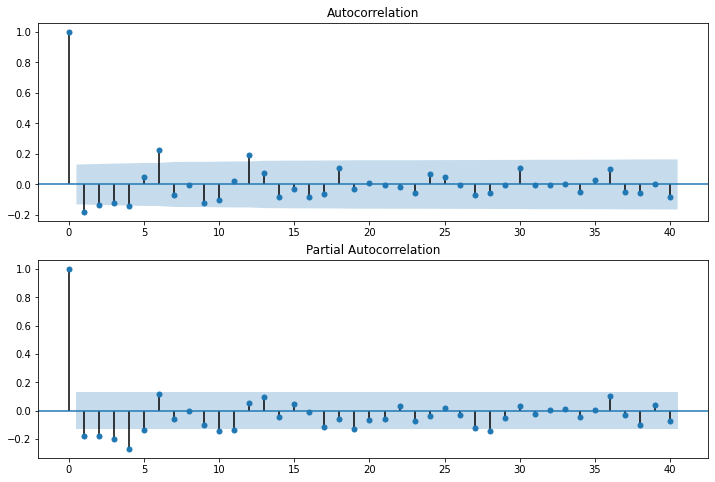

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

#Autocorrelation Graph for 40 periods
fig = sm.graphics.tsa.plot_acf(Train_second_difference.dropna(), lags=40, ax=ax1)

#Partial autocorrelation Graph for 40 periods
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Train_second_difference.dropna(), lags=40, ax=ax2)

In [36]:
from statistics import stdev
print("St.dev of original data:" , stdev(Train["Ln_Monthly_CPI"]))
print("St.dev of first difference:", stdev(Train_first_difference.dropna()))
print("St.dev of second difference:",stdev(Train_second_difference.dropna()))
print("St.dev of seasonal difference:",stdev(Train_seasonal_difference.dropna()))
print("St.dev of first and seasonal difference:",stdev(Train_seasonal_first_difference.dropna()))

St.dev of original data: 1.1963846004654612
St.dev of first difference: 0.026657521525112565
St.dev of second difference: 0.020912285673923593
St.dev of seasonal difference: 0.21571996196767804
St.dev of first and seasonal difference: 0.02944493728884312


In [37]:
y_hat_avg = Test.copy() 
fit1= SARIMAX(Train["Ln_Monthly_CPI"], order=(1,1,0),seasonal_order=(1,0,0,12),simple_differencing=False,enforce_stationarity=False,exog=Train["Dummy"]).fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Ln_Monthly_CPI   No. Observations:                  228
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 555.503
Date:                            Sun, 18 Sep 2022   AIC                          -1103.007
Time:                                    23:41:06   BIC                          -1089.543
Sample:                                         0   HQIC                         -1097.566
                                            - 228                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Dummy         -0.0105      0.002     -5.026      0.000      -0.015      -0.006
ar.L1          0.6934      0.028     24.638      0.000       0.638       0.749
ar.S.L12       0.2412      0.065      3.720      0.000       0.114       0.368
sigma2         0.0003   1.44e-05     22.663      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):              1363.24
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
length = Train.shape[0]-1
x = data.loc[length:,"Dummy"]
pred = pd.DataFrame(x)
pred.shape

(103, 1)

In [39]:
y_hat_avg['SARIMAX'] = fit1.predict(start=167, end=330, dynamic=True,return_conf_int=True,exog=pred) 

In [40]:
fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train['Ln_Monthly_CPI'], mode='lines', name= 'Train')))
fig.add_trace(go.Scatter(dict(x=Test.observation_date, y=Test['Ln_Monthly_CPI'], mode='lines', name= 'Test',line=dict(width=2))))
fig.add_trace(go.Scatter(dict(x=Test.observation_date, y=y_hat_avg['SARIMAX'], mode='lines', name= 'SARIMA',line=dict(width=2))))

fig.update_layout(title=go.layout.Title(
        text="SARIMAX Prediction",
        xref="paper",x=0),
        margin=dict(l=10, r=0, t=50, b=50),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="CPI",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()

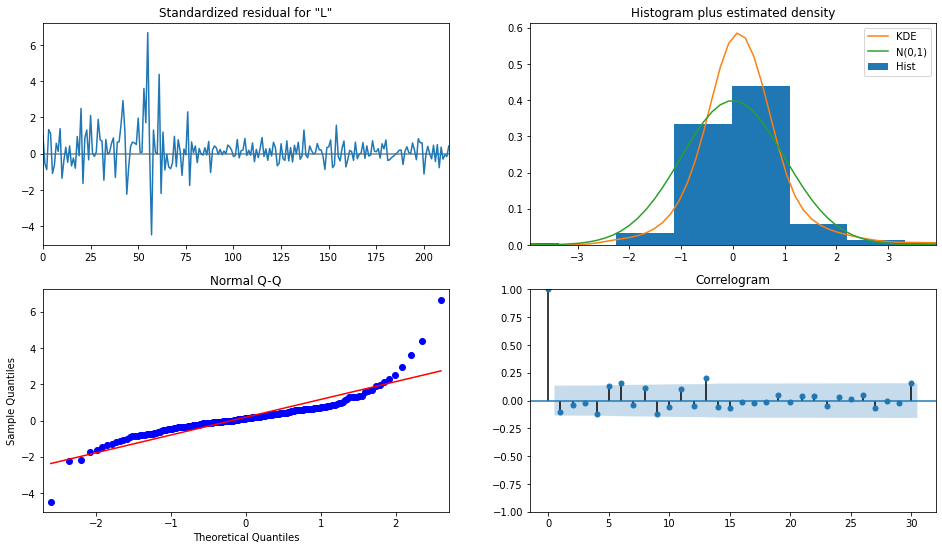

In [41]:
fig = plt.figure(figsize=(16, 9))
fig = fit1.plot_diagnostics(fig=fig, lags=30)

In [42]:
Test.Ln_Monthly_CPI=np.where(np.isnan(Test.Ln_Monthly_CPI), 0, Test.Ln_Monthly_CPI)
y_hat_avg.SARIMAX=np.where(np.isnan(y_hat_avg.SARIMAX), 0, y_hat_avg.SARIMAX)
rms = sqrt(mean_squared_error(Test.Ln_Monthly_CPI, y_hat_avg.SARIMAX.dropna())) 
print("\033[1m The root mean squared error of the predicted inflation by SARIMAX and CPI in the Test data set is "+ str(round(rms,4)))

 The root mean squared error of the predicted inflation by SARIMAX and CPI in the Test data set is 0.4257


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
std=Test.Ln_Monthly_CPI.std()
print("\033[1m The standard deviation of the CPI in the Test data set is " + str(round(std,4)))
error= round(round(rms,4) - round(std,4),4)
print("\033[1m The error in our model's prediction is " + str(error)+"%")

 The standard deviation of the CPI in the Test data set is 0.0607
 The error in our model's prediction is 0.365%


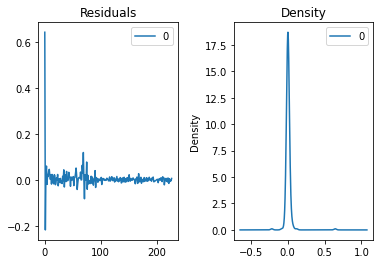

                0
count  228.000000
mean     0.006076
std      0.048516
min     -0.216466
25%     -0.004351
50%      0.002737
75%      0.010913
max      0.644034


In [44]:
#Plotting the residual density and estimating its distribution
residuals = pd.DataFrame(fit1.resid)
fig, ax = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.3, wspace=0.4)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(residuals.describe())

In [45]:
date_list = []
start = datetime.datetime(2022,7,1)
for x in range(0,50): 
    dates = (start + relativedelta(months=x)).strftime("%Y-%m-%d")
    date_list.append(dates)
col = pd.Series(date_list)
df = pd.DataFrame()
df['observation_date'] = col
data = pd.concat((data,df))
data.reset_index(inplace=True)

In [46]:
fit3= SARIMAX(data["Ln_Monthly_CPI"], order=(1,1,0),seasonal_order=[1,0,0,12],exog=data["Dummy"].fillna(0)).fit()

In [47]:
forecast = fit3.predict(start=330, dynamic= True) 
cpi = pd.Series(forecast)
cpi_rate = pd.DataFrame()
cpi_rate['Ln_Monthly_CPI'] = cpi
data.loc[329:, 'Ln_Monthly_CPI'] = cpi_rate['Ln_Monthly_CPI']
data

,index,observation_date,Monthly_CPI,Ln_Monthly_CPI,Year,Month,Dummy
0,0,1995-01-01 00:00:00,1.904146,0.644034,1995.0,Jan,0.0
1,1,1995-02-01 00:00:00,1.917188,0.650860,1995.0,Feb,0.0
2,2,1995-03-01 00:00:00,1.975878,0.681013,1995.0,Mar,0.0
3,3,1995-04-01 00:00:00,2.145425,0.763338,1995.0,Apr,0.0
4,4,1995-05-01 00:00:00,2.230198,0.802091,1995.0,May,0.0
...,...,...,...,...,...,...,...
375,45,2026-04-01,NaN,5.228170,NaN,NaN,NaN
376,46,2026-05-01,NaN,5.228218,NaN,NaN,NaN
377,47,2026-06-01,NaN,5.228274,NaN,NaN,NaN
378,48,2026-07-01,NaN,5.228317,NaN,NaN,NaN


In [48]:
fig= go.Figure()

fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train["Ln_Monthly_CPI"], mode='lines', name='Data')))
fig.add_trace(go.Scatter(dict(x=Test.observation_date, y=Test["Ln_Monthly_CPI"], mode='lines', name='Data')))
fig.add_trace(go.Scatter(dict(x=data.loc[329:, "observation_date"], y=forecast, mode='lines', name="Forecast")))

fig.update_layout(title=go.layout.Title(
        text="Forecasted Monthly CPI",
        xref="paper",x=0),
    margin=dict(l=10, r=0, t=100, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="CPI",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))

fig.show()